# Atomic Experiments in Deep Learning

_Deep Learning has been compared to electricity. I'd like to provide another analogy: alchemy._ -- Ali Rahimi, NIPS 2017

* Deep learning remains somewhat of a mysterious art even for frequent practitioners, because we usually run complex experiments on large datasets, which obscures basic relationships between dataset, hyperparameters, and performance.
* The goal of this notebook is to provide some basic intuition of deep neural networks by running very simple experiments on small datasets that help understand trends that occur generally on larger datasets. The experiments are designed to be "atomic" in that they try to test one fundamental aspect of deep learning in a controlled way. Furthermore, the experiments do not require specialized hardware (they all run in a few minutes without GPUs. See the elapsed time, measured on a CPU-only machine).
* All of the experiments here are written in Python using the [tensorflow](https://www.tensorflow.org/) and [sklearn](http://scikit-learn.org) libraries, but most of the code has been abstracted away to make the experiments easier to run. See the accompanying `experiments.py` file for full code. 

In [2]:
import tensorflow as tf, numpy as np, matplotlib.pyplot as plt
from utils import *
from experiments import *

pretty_plotting_styles()
timer = Timer()

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# I. Basics 

## 1. Why Use Neural Networks in the First Place?

The [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), states that a simple feedforward neural network (i.e. a multilayer perceptron) with a single hidden layer and a standard activation function can approximate any continuous function, if the hidden layer has a sufficient number of units. Let's show this in practice by seeing how many units it takes to approximate some select functions.

**Method:** We'll train a 1-layer neural network on 50 datapoints $(x,y)$ that are drawn from the following functions on the domain $[-1,1]$, and measure the mean square error (MSE) of the resulting fit. We'll try out the following functions (feel free to try your own by changing the code below!):

* $f(x) = \sin(12x)$
* $g(x) = -2x^4 + x^3 + x^2 - 2x + 0$
* $h(x) = \lvert x \rvert$


**Hypothesis:** As the number of units in the hidden layer increases, the accuracy of the resulting fit will increase (error will decrease).

Time needed to run experiment: 91.595 s


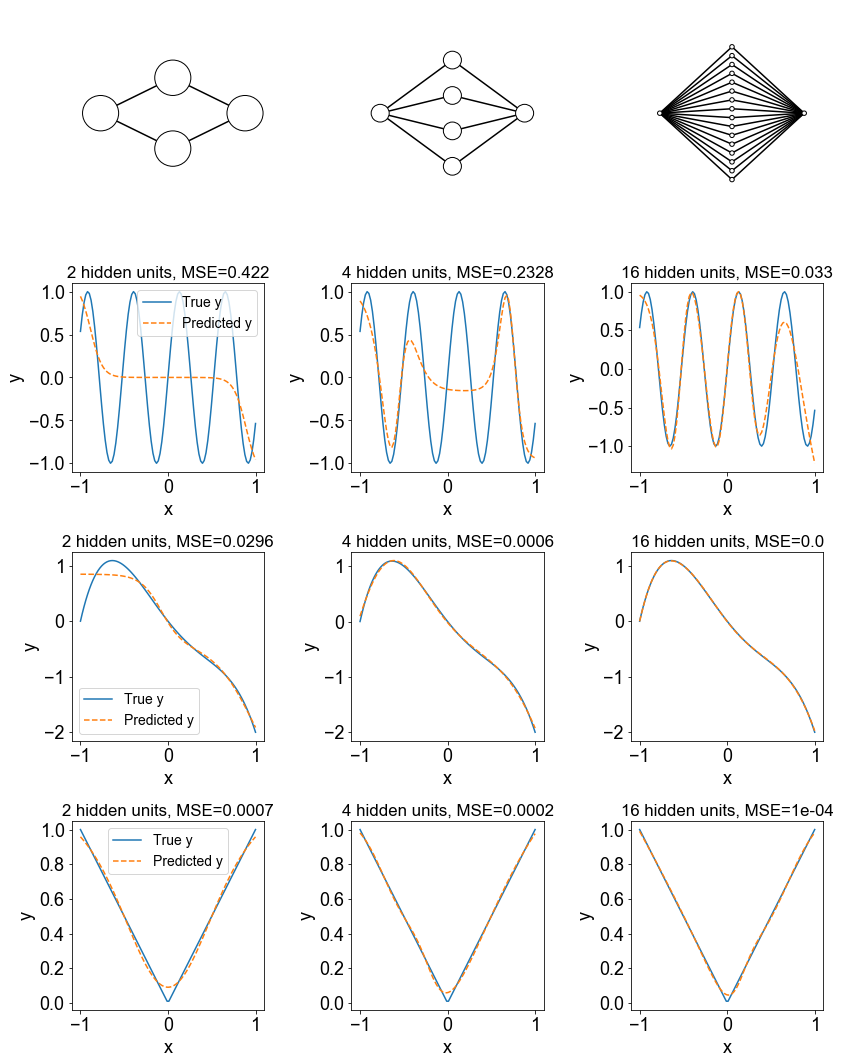

In [42]:
functions = [sin(omega=12),
             polynomial([0,-2,1,1,-2]),
             np.abs]
n_hidden_units = [2,4,16] 
experiment = Experiment1()

f, axs = plt.subplots(4,3,figsize=(12,15))
plt.rc("font",family="sans-serif",size=14)

for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[0, i]
    ax.axis('off')
    draw_neural_net(ax, .15, .9, .1, .85, [1, n_hidden, 1])


experiment.initialize()
plot_idx = 1
for i, function in enumerate(functions):
    for j, n_hidden in enumerate(n_hidden_units):
        x_values, y_values, y_pred, loss = experiment.run(n_hidden=n_hidden, function=function, verbose=False)
        ax = axs[i+1, j]
        ax.plot(x_values, y_values, '-',label='True y')
        ax.plot(x_values, y_pred, '--',label='Predicted y')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        if (j==0):
            ax.legend()
        ax.set_title(str(n_hidden)+' hidden units, MSE='+str(np.round(loss,4)))
        
plt.tight_layout()
experiment.conclude()

**Conclusion:** As the number of hidden units increase, the approximation error on the training data generally decreases. 

**Discussion:** Although the universal approximation theorem says that neural network with enough parameters can approximate a true classification/regression function, it doesn't say anything about whether these parameters are _learnable_ through a procedure like stochastic gradient descent. Additionally, you might be wondering whether we can theoretically calculate how many neurons are needed to approximate a given function arbitrarily well. See [(Mhaskar, 1996)](https://pdfs.semanticscholar.org/694a/d455c119c0d07036792b80abbf5488a9a4ca.pdf) for some discussion of this.

## 2. Why are Deeper Networks Better?

In practice, deeper multilayer perceptrons (with more than 1 hidden layer) outperform shallow ones by a wide margin on many task of interest. Why might this be the case? It has been suggested that deeper neural networks _require fewer parameters_ to express many important classes of functions. It has been shown theoretically that expressing [simple radial functions](https://arxiv.org/pdf/1512.03965.pdf) and [compositional functions](https://arxiv.org/pdf/1603.00988.pdf) requires an exponentially large number of parameters using shallow networks, but not so for deep neural networks. Spoiler alert: I tried to experimentally verify these papers, but I was not able to do so (this does not invalidate the results of the paper -- just because a set of neural network parameters exist, does not mean they can be learned easily by stochastic gradient descent). The only result I was able to reproduce even somewhat reliably was from a [paper that proposed a family of difficult classification problems](https://arxiv.org/pdf/1509.08101.pdf) that are easier for deeper neural networks. This is what I show here.

** Method:**  The dataset consists of 16 equally-spaced points along the x-axis, with each pair of ajacent points belonging to opposite classes. A special kind of deep neural network (one that shares weights across layers) with a fixed number (152) of parameters but varying numbers of layers is tested.

**Hypothesis:** As the number of layers increase in a neural network with a fixed number of parameters, the accuracy on a difficult classification problem will improve.

Time needed to run experiment: 28.688 s


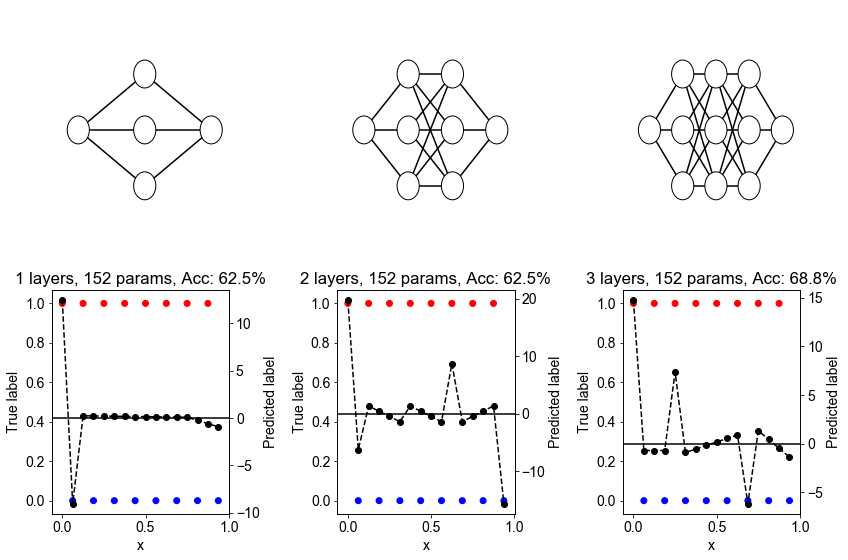

In [107]:
experiment = Experiment2()
experiment.initialize()

n_hidden_units = [[10],[10,10],[10,10,10]]

f, axs = plt.subplots(2,3,figsize=(12,8))
plt.rc("font",family="sans-serif",size=14)

for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[0, i]
    ax.axis('off')
    draw_neural_net(ax, .15, .9, .1, .85, [1] + [3]*len(n_hidden) + [1]) #10 hidden units per layer becomes too crowded

for i, n_hidden in enumerate(n_hidden_units):
    ax = axs[1, i]
    x_values,y_values,y_pred,loss,accuracy,n_params = experiment.run(n=16, n_hidden = n_hidden)
    ax.set_title(str(len(n_hidden))+' layers, '+str(n_params)+' params, Acc: '+str(np.round(100*accuracy,1))+'%')
    ax.set_xlabel('x')
    ax.set_ylabel('True label')
    ax.scatter(x_values, y_values[:,1], marker='o',c=y_values[:,1],cmap='bwr',label='Predicted y')
    ax2 = ax.twinx()
    ax2.plot(x_values, y_pred[:,1]-y_pred[:,0], 'k--o',label='Predicted y')
    ax2.axhline(0, color='k', ls='-')
    ax2.set_ylabel('Predicted label')

plt.tight_layout()
experiment.conclude()

Here, red and blue dots represent points that belong to different classes. The dashed-dotted black line is the closest approximation to the training data that is learned by the neural network (if the neural network assigns a score greater than zero, then a point is considered to be predicted as belonging to the red class. Otherwise, it is predicted to be blue). The zero line is shown in black.

** Conclusion:** Accuracy increases with increasing depth in most runs of the experiments. 

** Discussion:** It seems that deeper layers allow more "sharp turns" in the learned function from the input to the output. This seems to be related to some work on the [trajectory length](https://arxiv.org/pdf/1606.05336.pdf) of neural networks (a measure of how much the output of a neural network travels as the input varies along a 1D path of fixed length).

# II. Datasets

## 3. Does More Data Favor Deeper Neural Networks?

Deep learning and big data are closely linked; it's usually said that deep learning only works better than other techniques (such as shallow neural networks and random forests) when the size of the dataset grows large enough to overcome overfitting, and favor the increased expressivity of deep networks. We investigate this on a very simple dataset, consisting of a mixture of Gaussian samples. 

** Method: ** The dataset consists of a mixture of two 12-dimensional Gaussians, each of which generate data belonging to one class. The two Gaussians have the same covariance matrix, but have means that are $1/i$ unit apart in the $i^\text{th}$ dimension. The idea is to have some dimensions that allow models to easily discriminate between classes, while other dimensions are more difficult, but still useful, for discrimination.

**Hypothesis:** As the size of dataset increases, the test accuracy of all of the techniques will improve, but the accuracy of deep models will grow more than the non-deep models. We further expect the accuracy of the non-deep learning techniques to saturate more quickly.

Time needed to run experiment: 138.239 s


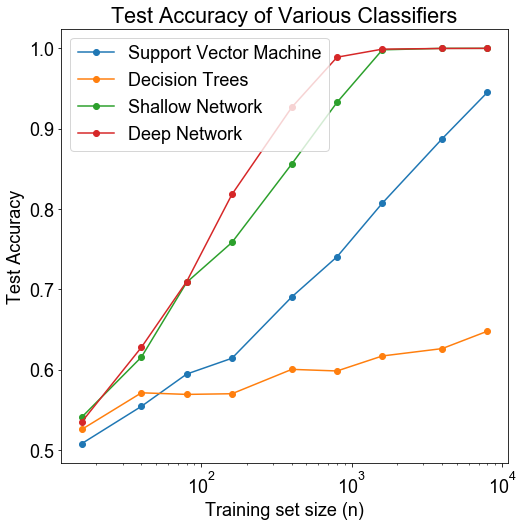

In [37]:
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC 

ns = [20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
test_size=0.2; train_size=1-test_size

class_seps = [1/(i+1) for i in range(12)]

classifiers = [SVC(),
               DecisionTreeClassifier(),
               MLPClassifier(),
               MLPClassifier(hidden_layer_sizes=(100,100)),
              ]

classifier_names = ['Support Vector Machine',
                    'Decision Trees',
                    'Shallow Network',
                    'Deep Network']

experiment = Experiment3()
experiment.initialize()

plt.figure(figsize=[8,8]); plt.rc("font",family="sans-serif",size=18)
accuracies = experiment.run(ns=ns,classifiers=classifiers,class_seps=class_seps,d=12,iters=3, test_size=test_size)
plt.title('Test Accuracy of Various Classifiers')
plt.plot(train_size*np.array(ns), np.mean(accuracies,axis=2), '-o')
plt.xlabel('Training set size (n)')
plt.ylabel('Test Accuracy')
plt.xscale('log')
plt.legend(classifier_names)

experiment.conclude()

** Conclusion:** The neural networks consistently perform better than SVMs and random forests across dataset size. The gap in performance increases as dataset size increases in, at least until the accuracy of the neural networks begin to saturate, suggesting that the neural networks are more efficiently able to take advantage of increasing dataset size. However, with enough data, even SVMs have a respectable accuracy. Deep networks perform a little bit better than shallow networks.

** Discussion: ** Although increasing dataset size does tend to favor neural networks as we expected, it is interesting that the neural networks are already better than other techniques on relatively small datasets. It seems that the 2-layer network isn't significantly overfitting, even though we would expect some features (say features 6-12, which have low levels of signal) to cause the networks to overfit. It's also interesting that the SVM seems like it could have an approaching 1.0 with enough data.

## 4. Does Unbalanced Data Hurt Neural Networks?

When datasets are unbalanced (if there are many more examples of one class than another), then neural networks may not be able to learn how to distinguish the classes. In this experiment, we explore whether this is the case, and we also explore whether *oversampling*, a popular remedy in which samples from the minority class are sampled with replacement, can mitigate the probelm.

** Method **: We generate a mixture of two 2-dimensional (results not shown here indicated that the same results hold for higher dimensions) Gaussians, each of which generate data belonging to one class. The two Gaussians have the same covariance matrix, but have means that are $1/i$ unit apart in the $i^\text{th}$ dimension. Each training dataset consists of 1,200 data points, but we vary the class imbalance from 1:1 to 1:99. The **test dataset remains fixed at a 1:1 ratio** to make it easy to compare performance, and consists of 300 points. We also show the decision boundary in each case.

** Hypothesis **: We expect test accuracy to decrease with increasing class imbalance, but we expect oversampling to mitigate this problems.

Time needed to run experiment: 392.157 s


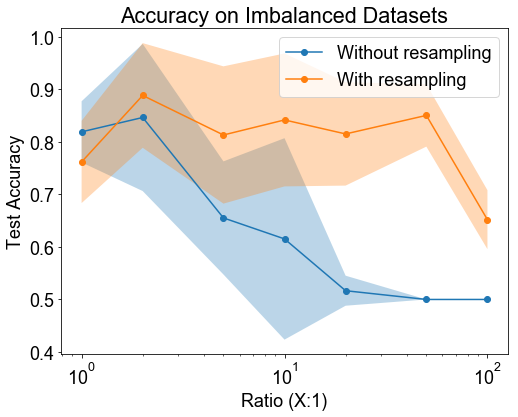

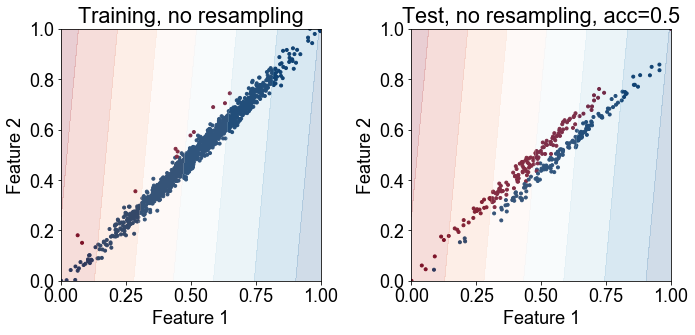

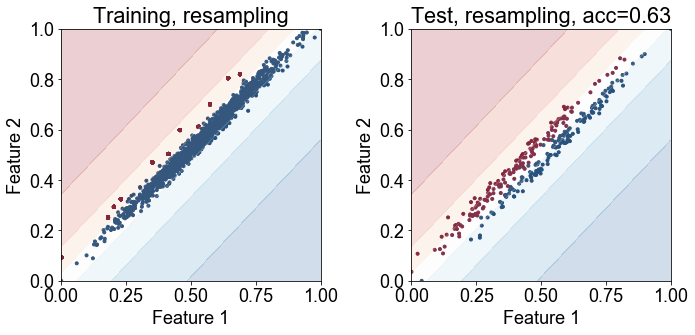

In [13]:
ratios = [1, 2, 5, 10, 20, 50, 100]
experiment = Experiment4()
experiment.initialize()

plt.figure(figsize=[8,6]); plt.rc("font",family="sans-serif",size=18)

accuracies, saved_covs = experiment.run(ratios=ratios, 
                                        d=2, 
                                        iters=5, 
                                        resample=False)
plt.plot(ratios, np.mean(accuracies,axis=1), '-o')
plt.fill_between(ratios, np.mean(accuracies,axis=1)-np.std(accuracies,axis=1),np.mean(accuracies,axis=1)+np.std(accuracies,axis=1), alpha=0.3)

accuracies, _ = experiment.run(ratios=ratios, 
                               d=2, 
                               iters=5, 
                               resample=True, 
                               load_covs=saved_covs)

plt.plot(ratios, np.mean(accuracies,axis=1), '-o')
plt.fill_between(ratios, np.mean(accuracies,axis=1)-np.std(accuracies,axis=1),np.mean(accuracies,axis=1)+np.std(accuracies,axis=1), alpha=0.3)

plt.title('Accuracy on Imbalanced Datasets')
plt.xlabel('Ratio (X:1)')
plt.ylabel('Test Accuracy')
plt.xscale('log')
plt.legend(['Without resampling','With resampling'])

plt.figure(figsize=[10,5]); plt.rc("font",family="sans-serif",size=18)

accuracies, saved_covs, X_train, y_train, X_test, y_test, y_pred, grid_pred = experiment.run(ratios=[100], 
                                                                                             d=2, 
                                                                                             iters=1, 
                                                                                             resample=False, 
                                                                                             classify_grid=True)

plt.subplot(1,2,1)
plot_decision_boundary(X_train, y_train, grid_pred)
plt.title('Training, no resampling')
plt.subplot(1,2,2)
plot_decision_boundary(X_test, y_test, grid_pred)
plt.title('Test, no resampling, acc='+str(round(accuracies[0][0],2)))
plt.tight_layout()

plt.figure(figsize=[10,5]); plt.rc("font",family="sans-serif",size=18)

accuracies, _, X_train, y_train, X_test, y_test, y_pred, grid_pred = experiment.run(ratios=[100], 
                                                                                    d=2, 
                                                                                    iters=1, 
                                                                                    resample=True, 
                                                                                    classify_grid=True, 
                                                                                    load_covs=saved_covs)

plt.subplot(1,2,1)
plot_decision_boundary(X_train, y_train, grid_pred)
plt.title('Training, resampling')
plt.subplot(1,2,2)
plot_decision_boundary(X_test, y_test, grid_pred)
plt.title('Test, resampling, acc='+str(round(accuracies[0][0],2)))
plt.tight_layout()

experiment.conclude()

The bottom four plots show countours of the decision boundary plotted along with the training points (left) or test points (right). The top row shows the result without resampling and the bottom with resampling.

**Conclusion**: The results show that class imblaance certainly does reduce classification accuracy. Resampling can significantly improve the performance..

**Discussion**: It is perhaps surprising that resampling has a significant effect in improving classification accuracy, since it does not expose the classifier to *new* training examples from the minority class. But the plots suggest that resampling is enough "nudge" or rotate the decision boundary in the right direction. In cases where resampling is not effective alone, complex methods to [synthesize new training examples](http://www.jair.org/media/953/live-953-2037-jair.pdf) from the minority class may be needed to improve accuracy.

## 5. How Do You Tell if a Neural Networks is Memorizing Or Generalizing?

Neural networks with many parameters have the capacity to memorize lots of training examples. So are neural networks simply memorizing the training examples (and then simply classifying test points based on the closest similar training point), or are they actually picking up patterns and generalizing? Is there any difference? One reason to think there is a difference is if the _speed_ at which a neural network learns randomly-assigned labels is different than it which it learns reaon labels. This is one of strategies used in the [paper by Arpit et al.](https://arxiv.org/pdf/1706.05394.pdf). Let's see if we see a difference.

**Method**: First, we generate a mixture of 6-dimensional Gaussians and randomly assign them labels. We measure the accuracy on the *training data* for increasing data set sizes to get a sense of the _capacity_ of a neural network to memorize. We then choose a dataset size within the capacity of a neural network to memorize and observe whether there are qualitative differences between a neural network during training that is learning random labels versus real labels. In particular, we look at the accuracy per epoch to determine whether neural networks that are learning true labels or random labels.

**Hypothesis**: We expect that training should take longer for random labels as opposed to real labels.

Time needed to run experiment: 432.275 s


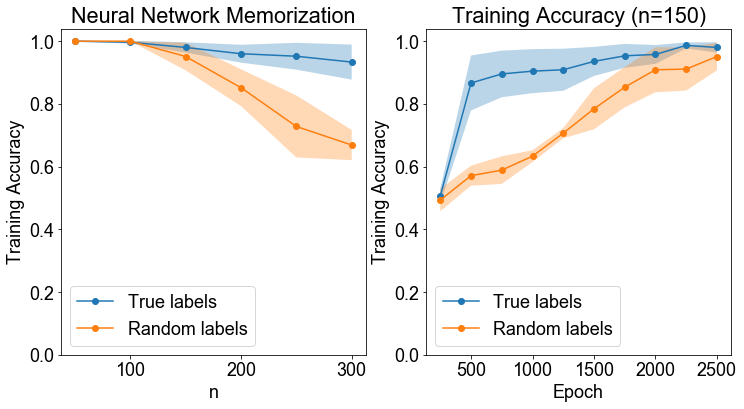

In [3]:
ns = [50, 100, 150, 200, 250, 300]
experiment = Experiment5()
experiment.initialize()

plt.rc("font",family="sans-serif",size=18)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])

accuracies = experiment.run(ns=ns,hidden_layer_sizes=[200,200,200], return_accuracy_per_epoch=True)
ax1.plot(ns, np.mean(accuracies[-1],axis=1), '-o')
ax1.fill_between(ns, np.mean(accuracies[-1],axis=1)-np.std(accuracies[-1],axis=1),np.mean(accuracies[-1],axis=1)+np.std(accuracies[-1],axis=1), alpha=0.3)
ax1.set_ylim([0,1.04])

steps = np.linspace(250,2500,10)
ax2.plot(steps, np.mean(accuracies[:,2,:],axis=1), '-o')
ax2.fill_between(steps, np.mean(accuracies[:,2,:],axis=1)-np.std(accuracies[:,2,:],axis=1),np.mean(accuracies[:,2,:],axis=1)+np.std(accuracies[:,2,:],axis=1), alpha=0.3)
ax2.set_ylim([0,1.04])

accuracies = experiment.run(ns=ns,hidden_layer_sizes=[200,200,200], randomize=True, return_accuracy_per_epoch=True)
ax1.plot(ns, np.mean(accuracies[-1],axis=1), '-o')
ax1.fill_between(ns, np.mean(accuracies[-1],axis=1)-np.std(accuracies[-1],axis=1),np.mean(accuracies[-1],axis=1)+np.std(accuracies[-1],axis=1), alpha=0.3)
ax1.legend(['True labels', 'Random labels'])
ax1.set_xlabel('n')
ax1.set_ylabel('Training Accuracy')
ax1.set_title('Neural Network Memorization')

ax2.plot(steps, np.mean(accuracies[:,2,:],axis=1), '-o')
ax2.fill_between(steps, np.mean(accuracies[:,2,:],axis=1)-np.std(accuracies[:,2,:],axis=1),np.mean(accuracies[:,2,:],axis=1)+np.std(accuracies[:,2,:],axis=1), alpha=0.3)
ax2.legend(['True labels', 'Random labels'])
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Training Accuracy')
ax2.set_title('Training Accuracy (n=150)')

experiment.conclude()

**Conclusion**: The capacity of the neural network to memorize seems to be about 150 training points. But, even then, the neural network takes longer to learn random labels as opposed to ground truth labels.

**Discussion**: This result is not very surprising. We would expect true labels to be learned more quickly -- when a neural network learns to correctly classify one particular data point, it will also learn to classify other similar data points -- if the labels are sensical, but not if they are random!

## 6. Does Unsupervised Dimensionality Reduction Help or Hurt?

When dealing with very high dimensional data, it may be difficult for a neural network to learn the correct classification boundary. In these situations, one may consider doing unsupervised dimensionality reduction before passing the data into the neural network. Does this help or hurt?

**Method**: We generate a mixture of two 10-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. We then add to the data "dummy dimensions" which are features that take very low random values for both types of Gaussians, and are thus not useful for classification. We then apply multiply the resulting data by a random rotation matrix to obfuscate the dummy dimensions. The small dataset size ($n=100$) makes it difficult for a neural network to learn the classification boundary. So we PCA the data into a smaller number of dimensions and see if the classification accuracy increases.

**Hypothesis**: We expect that PCA will help since the directions with the most variation also (likely) correspond to the directions that are the most useful for classification.

Time needed to run experiment: 182.938 s


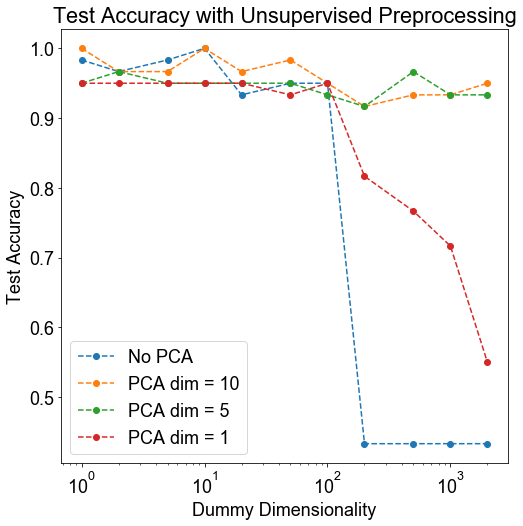

In [75]:
experiment = Experiment6()
experiment.initialize()

dummy_dims = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 2000]
pca_dims = [None, 10, 5, 1]

accuracies = experiment.run(dummy_dims=dummy_dims, 
                               noise_level=1,
                               pca_dims=pca_dims)

plt.figure(figsize=[8,8]); plt.rc("font",family="sans-serif",size=18)
plt.plot(dummy_dims, np.mean(accuracies,axis=0), '--o')

plt.title('Test Accuracy with Unsupervised Preprocessing')
plt.xlabel('Dummy Dimensionality')
plt.ylabel('Test Accuracy')
plt.xscale('log')
plt.legend(['No PCA', 'PCA dim = 10', 'PCA dim = 5', 'PCA dim = 1'])

experiment.conclude()

**Conclusion**: An unsupervised PCA step can provide significant improvement in downstream classification when the dimensionality is very large.

**Discussion**: We observe an interesting thresholding behavior. When the dimensionality increases beyond 100 (which, interestingly, is the number of data points in the dataset -- this should be explored further), the quality of classification drops significantly. In these cases, PCA to 5 or 10 dimensions significantly improves downstream classification

# III. Parameters and Hyperparameters

## 7. Can Any Non-Linearity be Used as the Activation Function?

Many research papers have been published on marginal improvements obtained by neural networks with special activation functions beyond the typical $\text{ReLU}(\cdot)$'s and $\tanh(\cdot)$. Instead of trying to develop specialized activation functions, we simply ask whether it is possibly to use any old non-linear function in a neural network? 

**Method**: We generate the famous two-dimensional moons dataset, and train a neural network with 2 hidden layers to learn to classify the dataset. We try 7 different activation functions:

* $ f(x) = \text{ReLU}(x) $
* $ f(x) = \tanh(x) $
* $ f(x) = x^2 $
* $ f(x) = \sin(x) $
* $ f(x) = \text{sign}(x) $
* $ f(x) = x $

**Hypothesis**: We would expect that the identity function to perform poorly (as the network remains quite linear until the last softmax layer). We might further expect that the standard activation functions to perform the best.

Time needed to run experiment: 239.783 s


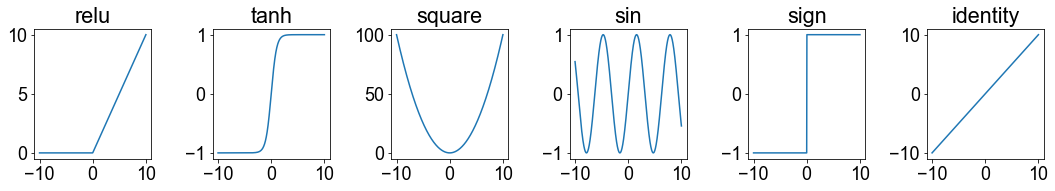

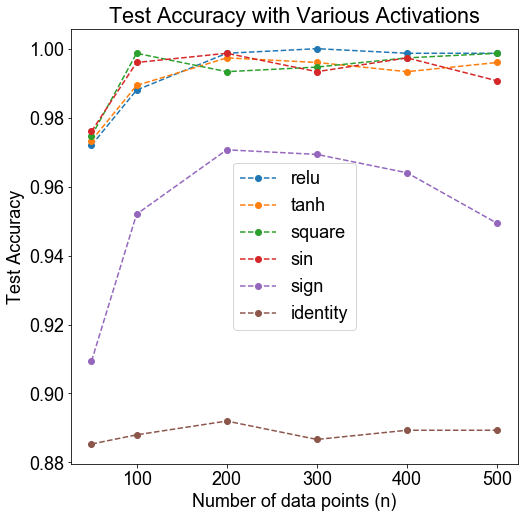

In [40]:
experiment = Experiment7()
experiment.initialize()

ns = [50, 100, 200, 300, 400, 500]
activations = [tf.nn.relu, tf.tanh, tf.square, tf.sin, tf.sign, tf.identity]

accuracies = experiment.run(activations=activations, 
                            iters=6,
                            ns=ns)

fig, axs = plt.subplots(1, 6, figsize=[15,3])
sess = tf.Session()
for i, ax in enumerate(axs):
    ax.plot(x, sess.run(activations[i](x)))
    ax.set_title(activations[i].__name__)
plt.tight_layout()

plt.figure(figsize=[8,8]); plt.rc("font",family="sans-serif",size=18)
plt.plot(ns, np.mean(accuracies,axis=0), '--o')

plt.title('Test Accuracy with Various Activations')
plt.xlabel('Number of data points (n)')
plt.ylabel('Test Accuracy')
plt.legend([a.__name__ for a in activations])

experiment.conclude()

**Conclusion**: All of the non-linear activation functions besides $\text{sign}(x)$ are quite effective for this classification task. 

**Discussion**: The results are somewhat surprising since all of the functions are about equally effective. In fact, symmetric activation functions, like $x^2$ seem to be performing as well as $\text{ReLUs}$! There are a couple of reasons we should be careful about extrapolating too much from this experiment. For one, this is a relatively shallow neural network. Activation functions that are good for this kind of network may be very different than those that are good for deeper networks. Furthermore, this task may have been too easy -- as even the almost completely linear neural network ($f(x) = x$) achieves about 88% accuracy!

## 8. How Does Batch Size Affect Test Accuracy?

**Method**: We generate a mixture of two 12-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. The dataset consists of 500 Gaussians, of which 400 are used to train, and 100 used to test. We train a neural network on this dataset with batches of different sizes from a batch size of 1 to a batch size of 400. We measure both the accuracy after 

**Hypothesis**: We expect that larger batch sizes will increase test accuracy (less noisy gradient updates), up to a certain extent, after which the test accuracy will decrease. We expect the running time to go down with increasing batch size.

Time needed to run experiment: 340.291 s


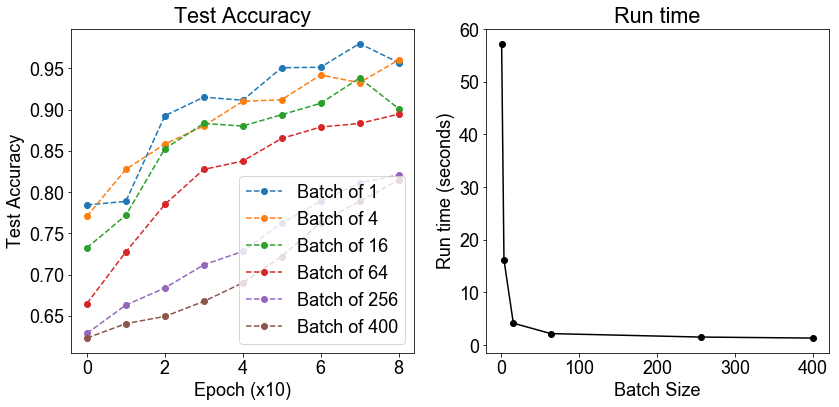

In [4]:
experiment = Experiment8()
experiment.initialize()

batch_sizes = [1, 4, 16, 64, 256, 400]
runtimes, accuracies = experiment.run(iters=4, 
                                      batch_sizes=batch_sizes, 
                                      return_accuracy_per_epoch=True)

plt.figure(figsize=[12,6]); plt.rc("font",family="sans-serif",size=18)
plt.subplot(1,2,1)
plt.plot(np.mean(accuracies,axis=2), '--o')

plt.title('Test Accuracy')
plt.xlabel('Epoch (x10)')
plt.ylabel('Test Accuracy')
plt.legend(['Batch of ' + str(b) for b in batch_sizes])

plt.subplot(1,2,2)
plt.plot(batch_sizes, runtimes, 'k-o')

plt.title('Run time')
plt.xlabel('Batch Size')
plt.ylabel('Run time (seconds)')
plt.tight_layout()

experiment.conclude()

**Conclusion**: The running time did decrease with increasing batch size, as we expected. However, this led to a compromise in test accuracy, as the test accuracy monotonically decreased with increasing batch size.

**Discussion**: This is pretty interesting, and is not in agreement with the widespread idea that moderately large batch sizes are strictly better for training. Perhaps, this dataset is not that difficult and so noisy gradients are not an issue? This would explain why training accuracy did not increase with increasing batch size, but it does not explain why batch size decreases so sharply with increasing batch sizes.

## 9. Does the Loss Function Matter?

For classification tasks, the cross-entropy loss is commonly used. What if we use mean-squared error instead, as is usually done on regression tasks? Does it matter which one we choose?

**Method**: We generate a mixture of two 12-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. The dataset consists of 500 Gaussians, of which 400 are used to train, and 100 used to test. We train a neural network on this dataset with several different loss functions to see whether there are systematic differences in the final accuracy. As a negative control, a constant loss is included.

**Hypothesis**: We expect the cross entropy loss, as the standard loss function used for classification tasks, to perform the best, while we expect the other loss funtions to not perform as well. 

Time needed to run experiment: 218.678 s


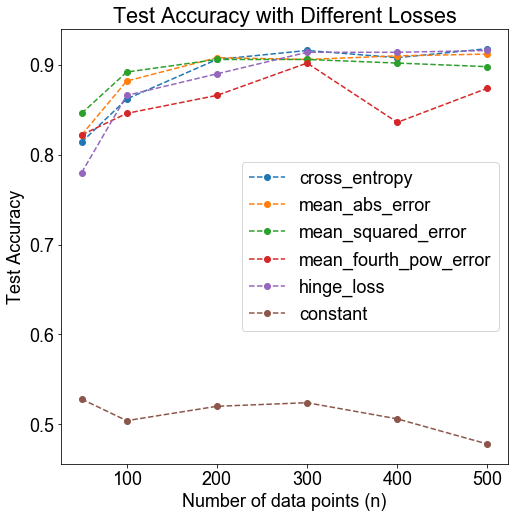

In [109]:
experiment = Experiment9()
experiment.initialize()

ns = [50, 100, 200, 300, 400, 500]
loss_functions = ['cross_entropy',
                  'mean_abs_error',
                  'mean_squared_error',
                  'mean_fourth_pow_error', 
                  'hinge_loss', 
                  'constant']

accuracies = experiment.run(loss_functions=loss_functions, 
                            iters=5,
                            ns=ns)

plt.figure(figsize=[8,8]); plt.rc("font",family="sans-serif",size=18)
plt.plot(ns, np.mean(accuracies,axis=0), '--o')

plt.title('Test Accuracy with Different Losses')
plt.xlabel('Number of data points (n)')
plt.ylabel('Test Accuracy')
plt.legend(loss_functions)

experiment.conclude()

**Conclusion**: All of the losses had similar performance, besides the negative control. The loss function that is the difference between the labels and logits raised to the fourth power, had performance slightly worse than the others. 

**Discussion**: It is perhaps not too surprising that the choice of loss function does not have a substantial effect on the final outcome, since these loss functions are quite similar.

## 10. How Does Initialization Affect Training?

**Method**: We generate a mixture of two 12-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. The dataset consists of 500 Gaussians, of which 400 are used to train, and 100 used to test. We train a neural network on this dataset with methods used to initiailize the weights in this neural network, to see which has the best training performance.

**Hypothesis**: We expect the Xavier loss to have the best performance (it is the default used in tensorflow), while the other methods to have poor preformance (especially the constant initiailizers).

Time needed to run experiment: 27.477 s


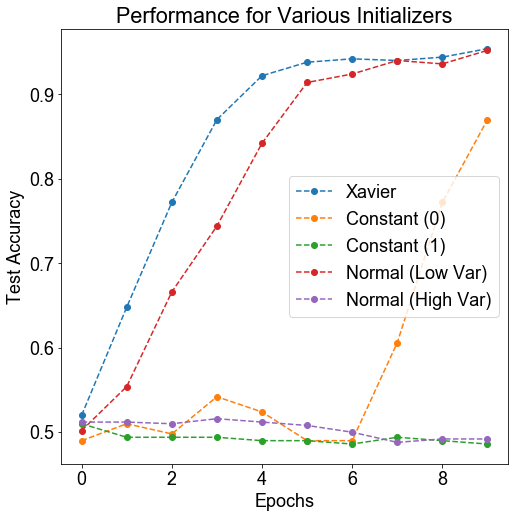

In [15]:
experiment = Experiment10()
experiment.initialize()

initializers = [tf.contrib.layers.xavier_initializer(),
                tf.zeros_initializer(),
                tf.ones_initializer(),
                tf.random_normal_initializer(0,0.01),
                tf.random_normal_initializer(0,10),
               ]

accuracies = experiment.run(initializers=initializers, 
                            iters=5)

plt.figure(figsize=[8,8]); plt.rc("font",family="sans-serif",size=18)
plt.plot(np.mean(accuracies,axis=0), '--o')

plt.title('Performance for Various Initializers')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend(['Xavier','Constant (0)','Constant (1)','Normal (Low Var)','Normal (High Var)'])

experiment.conclude()

**Conclusion**: The Xavier and Gaussian (with lower variance) initializations lead to very good training. Interestingly, the constant 0 initiailazation eventually leads to training, while the other initializations do not.

**Discussion**: It is not very surprising that Xavier initialization offers the best performance. A Gaussian distribution with a small standard deviation works as well (but not as good as Xavier). If the variance becomes too big, then training does not happen, probably because the outputs through the neural network explode. Interestingly, the constant initialization (which theoretically should not be able to train a neural network) leads to training after several epochs. This is probably due to small numerical errors, which lead to divergence of different weights. Interestingly, this doesn't work when the weights are all equally 1.

# V. Weight Evolution

In this section, we examine the values of the weights of the neural network, and visualize how they change throughout training.

## 11. Do Weights in Different Layers Converge at Different Speeds? 

The first question that we ask is whether the weights in different layers converge at different speeds.

**Method**: We generate a mixture of two 12-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. The dataset consists of 500 Gaussians, of which 400 are used to train, and 100 used to test. We train a neural network with 3 hidden layers (leading to 4 layers of weights, including the weights from input to layer 1) on this dataset, and we plot the values of 50 weights from each layer throughout training. We measure convergence by plotting the norm of the difference of the weights between adjacent epochs.

**Hypothesis**: We might expect that the weights of later layers converge more quickly, as the changes in later stages get amplified as they propagate backwards throughout the network.

Time needed to run experiment: 3.924 s


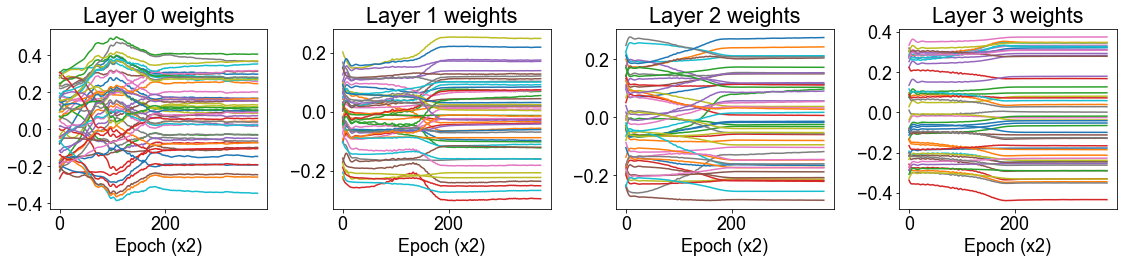

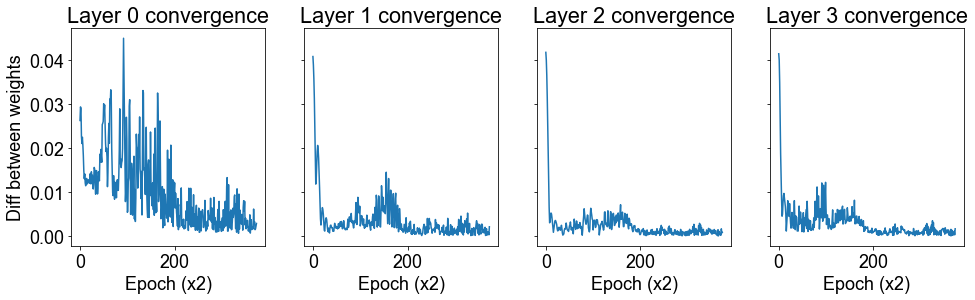

In [101]:
experiment = Experiment11()
experiment.initialize()

num_steps = 750
num_weights = 50
num_layers = 4
store_every = 2
wts, accs = experiment.run(num_steps=num_steps, store_every=store_every)

weights = np.zeros((int(num_steps/store_every), num_layers, num_weights))
for i in range(int(num_steps/store_every)):
    for j in range(num_layers):
        weights[i,j] = wts[i][j].flatten()[-num_weights:]

fig, axs = plt.subplots(1, 4, figsize=[16,4])
for j in range(num_layers):
    axs[j].plot(weights[:,j])
    axs[j].set_xlabel('Epoch (x2)')
    axs[j].set_title('Layer '+str(j)+' weights')
plt.tight_layout()
    
fig, axs = plt.subplots(1, 4, figsize=[16,4], sharey=True)
axs[0].set_ylabel('Diff between weights')
for j in range(num_layers):
    axs[j].plot(np.linalg.norm(np.diff(weights[:,j],axis=0),axis=1))
    axs[j].set_xlabel('Epoch (x2)')
    axs[j].set_title('Layer '+str(j)+' convergence')
    
experiment.conclude()

**Conclusion**: We find that the weights in later layers do converge more quickly than weights in the earlier layers.

**Discussion**: It seems that weights in layers 3 converge almost monotonically to their final values, and do so rather quickly. The convergence patterns of the weights in previous layers are more complicated and they seem to take longer to settle. 

## 12. How Does Regularization Affect the Weights?

**Method**: We generate a mixture of two 12-dimensional Gaussians. The Gaussians have the same covariance matrix, but have means that are separated by 1 in every dimension. The dataset consists of 500 Gaussians, of which 400 are used to train, and 100 used to test. We train a neural network with 2 hidden layers on this dataset, and we plot the values of 50 weights throughout training. We then repeat the process after including an L1 or L2 regularization term in the loss function. We examine whether this affects the convergence of the weight. We also plot the accuracy, and determine whether it changes significantly in the presence of regularization.

**Hypothesis**: We would expect that the magnitude of the weights to be lower in the presence of regularization. We may end up with sparse weights in the case of L1 regularization. We would expect accuracy to go down if the regularization strength is high, but the accuracy may actually go up with mild regularization.

Time needed to run experiment: 17.761 s


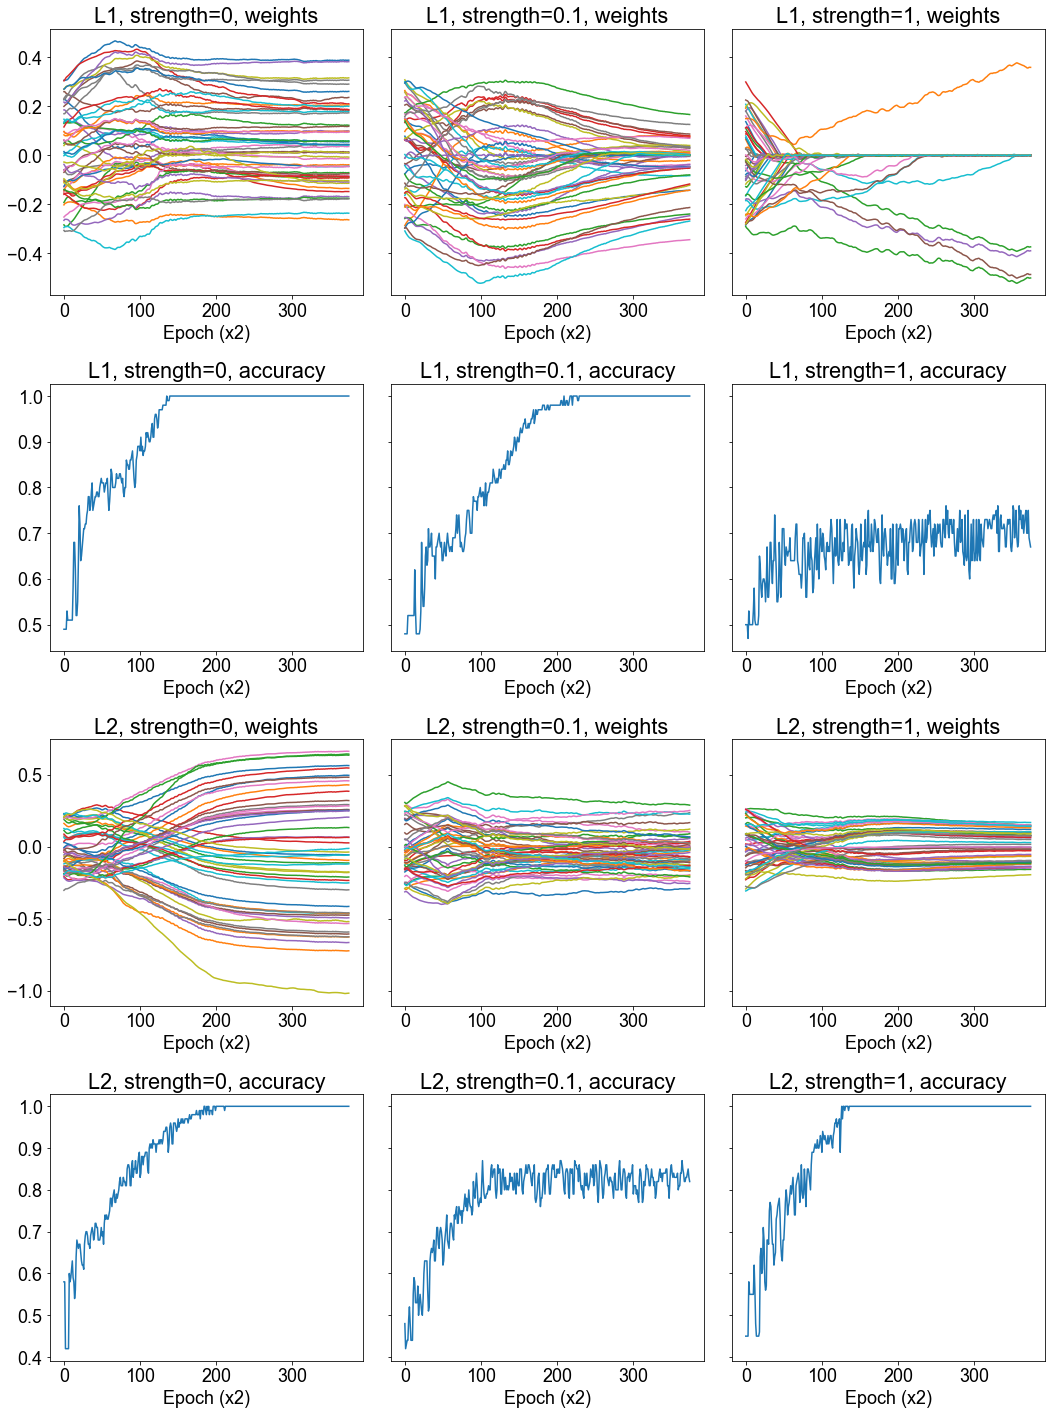

In [124]:
experiment = Experiment12()
experiment.initialize()

num_steps = 750
num_weights = 50
num_layers = 4
store_every = 2
regularization_types = ['L1','L2']
regularization_strengths = [0, 0.1, 1]


weights = np.zeros((int(num_steps/store_every), num_weights))

fig, axs = plt.subplots(2*len(regularization_types), 
                        len(regularization_strengths), 
                        figsize=[15,20],
                        sharey='row')

plt.rc("font",family="sans-serif",size=18)

for k, typ in enumerate(regularization_types):
    for j, lamb in enumerate(regularization_strengths):
        wts, accs = experiment.run(num_steps=num_steps, 
                                   store_every=store_every,
                                   regularization_type=typ,
                                   regularization_strength=lamb,
                                  )
        
        for i in range(int(num_steps/store_every)):
            weights[i] = wts[i][0].flatten()[-num_weights:]
                    
        axs[2*k,j].plot(weights)
        axs[2*k,j].set_xlabel('Epoch (x2)')
        axs[2*k,j].set_title(typ + ', strength='+str(lamb) + ', weights')
        
        axs[2*k+1,j].plot(accs)
        axs[2*k+1,j].set_xlabel('Epoch (x2)')
        axs[2*k+1,j].set_title(typ + ', strength='+str(lamb) + ', accuracy')
        
plt.tight_layout()
        
experiment.conclude()

**Conclusion**: We note that regularization does indeed decrease the magnitude of the weights and in the case of strong L1 regularization, lead to sparsity. The effect on accuracy is less clear.

**Discussion**: It is very clear from the sample of 50 weights that we have chosen that regularization has a dramatic effect on the weights learned during training. We are able to obtain a degree of sparsity with L1 regularization, although it seems that with large regularization strength, this leads to a compromise in accuracy. L2 regularization does not lead to sparsity, only weights with smaller magnitude. At the same time, the effect on accuracy seems to be less detrimental.

# Final Notes

* We have barely begun to scratch the surface! For example, all of these experiments involve (not that deep) MLPs, and there are many experiments that would be fun to do with CNNs or RNNs. If you'd like to add an experiment, feel free to make a pull request. Here are some ideas that I think are worth exploring: 
    - What is the relationship between batch size and learning rate?
    - How does learning end-to-end compare with training neural networks separately on tasks?
    - What is batch normalization and why does it help?
    - Does transfer learning help neural networks when data is limited?

** _If this notebook was helpful in your research, please cite it using bibtex entry below:_ **

```
@misc{abid2018atomic,
  title={Atomic Experiments in Deep Learning},
  author={Abid, Abubakar},
  year={2018},
  publisher={GitHub},
  howpublished={\url{https://github.com/abidlabs/AtomsOfDeepLearning}},
}
```